# Libraries

In [5]:
!pip install rasterio
!pip install tensorflow_addons

import tensorflow as tf
import pickle as cPickle
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.models import Model
import os
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from csv import writer
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import tensorflow_addons as tfa


import rasterio
from rasterio.plot import show
import tifffile as tiff 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten


from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 55.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00


# Models

In [6]:
#model to merge S1 modality
class S1FeatureEmbed(tf.keras.Model):

    def __init__(self):
    super().__init__()
    self.standardize = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(semantic_emb_dim*2, activation=tf.keras.activations.relu)
    self.dense2 = tf.keras.layers.Dense(semantic_emb_dim*2, activation=tf.keras.activations.relu)
    self.dense3 = tf.keras.layers.Dense(semantic_emb_dim*2, activation=tf.keras.activations.relu)
    self.dense4 = tf.keras.layers.Dense(semantic_emb_dim*2, activation=tf.keras.activations.relu)
    self.dense5 = tf.keras.layers.Dense(int(semantic_emb_dim*1.5),activation=tf.keras.activations.relu)
    self.dense6 = tf.keras.layers.Dense(int(semantic_emb_dim*1.5),activation=tf.keras.activations.relu)
    self.dense7 = tf.keras.layers.Dense(semantic_emb_dim,activation=tf.keras.activations.relu)
    self.dense8 = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.standardize(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        return self.dense8(x)


#model to merge S2 modality
class S2FeatureEmbed(tf.keras.Model):

    def __init__(self):
    super().__init__()
    self.standardize = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(semantic_emb_dim*2,activation=tf.keras.activations.relu)
    self.dense2 = tf.keras.layers.Dense(semantic_emb_dim*2,activation=tf.keras.activations.relu)
    self.dense3 = tf.keras.layers.Dense(semantic_emb_dim*2,activation=tf.keras.activations.relu)
    self.dense4 = tf.keras.layers.Dense(semantic_emb_dim*2,activation=tf.keras.activations.relu)
    self.dense5 = tf.keras.layers.Dense(semantic_emb_dim*2,activation=tf.keras.activations.relu)
    self.dense6 = tf.keras.layers.Dense(int(semantic_emb_dim*1.5),activation=tf.keras.activations.relu)
    self.dense7 = tf.keras.layers.Dense(int(semantic_emb_dim*1.5),activation=tf.keras.activations.relu)
    self.dense8 = tf.keras.layers.Dense(int(semantic_emb_dim*1.5),activation=tf.keras.activations.relu)
    self.dense9 = tf.keras.layers.Dense(semantic_emb_dim,activation=tf.keras.activations.relu)
    self.dense10 = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.standardize(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        x = self.dense9(x)
        return self.dense10(x)


# model to predict the labels 
class LabelClassifier(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(2048,activation=tf.keras.activations.relu)
        self.dense2 = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu)
        self.dense3 = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu)
        self.dense4 = tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu)
        self.dense5 = tf.keras.layers.Dense(512,activation=tf.keras.activations.relu)
        self.dense6 = tf.keras.layers.Dense(512,activation=tf.keras.activations.relu)
        self.dense7 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        return self.dense7(x)

# flip gradiant model
class FlipGradientBuilder(object):
    def __init__(self):
        pass

    def __call__(self, x,lr =1.0):
        param = lr
        @tf.custom_gradient
        def grad_reverse(x):
            #y = tf.identity(x)
            def custom_grad(dy):
                return -dy*param
            return x, custom_grad
        return grad_reverse(x)


#model to classify the type of modalities
class ModalityClassifier(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.standardize = tf.keras.layers.BatchNormalization()

        self.flip = FlipGradientBuilder()
        self.dropout= tf.keras.layers.Dropout(0.7)
        self.dense1 = tf.keras.layers.Dense(int(semantic_emb_dim/2))
        self.dense2 = tf.keras.layers.Dense(int(semantic_emb_dim/2))
        self.dense3 = tf.keras.layers.Dense(int(semantic_emb_dim/2))
        self.dense4 = tf.keras.layers.Dense(2)

    def call(self, x, lr=1.0, training= False):
        x = self.flip(x,lr)
        if training:
            x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)


In [7]:
#baseline for S2 modality
class BaseLineS2(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.emb = S2FeatureEmbed()
        self.emb._name = 's2_emb'
        self.classfier  = LabelClassifier()


    def call(self, x):
        x = self.emb(x)
        return self.classfier(x)

#baseline for S1 modality
class BaseLineS1(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.emb = S1FeatureEmbed()
        self.emb._name = 's1_emb'
        self.classfier  = LabelClassifier()


    def call(self, x):
        x = self.emb(x)
        return self.classfier(x)

In [8]:
#feature extraction model 
def getResModel_remote(input_shape):

    model = Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=input_shape,
        weights =None,
        classes=10,))
    model.add(Flatten())
    model.add(Dense(units=2048,activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(units=2048,activation="relu", name="fc2"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(units=10, activation="softmax"))

    return model

# Functions for training

In [9]:
#files to find the feature space for each modality
data_info =[{
  #train feature space for s2
  "address":"s2_feature_res_train.csv",
  "type_data":"csv"
},
{
  #train feature space for s1
  "address": "s1_feature_train.csv",
  "type_data":"csv"
},
{
    #train labels
  "address": "train_labels.csv",
  "type_data": "csv"
},
{
    #test feature space for s2
  "address":"s2_feature_res_test.csv",
  "type_data": "csv"
},
{
    #test feature space for s1
  "address": "s1_feature_test.csv",
  "type_data": "csv"
},
{
    #test labels
  "address": "test_labels.csv",
  "type_data": "csv"
} ]

In [10]:
epoch = 50
margin = .1
alphtxt2imga = 5
alpha = 1
batch_size = 64
visual_feat_dim = 2048
word_vec_dim = 2048
lr_total = 0.0001
lr_emb = 0.0001
lr_domain = 0.0001
top_k = 50
semantic_emb_dim = 1024


classifier_optimizer =tf.keras.optimizers.Adam(learning_rate=lr_emb, beta_1=0.5)
tripple_optimizer_s2 =tf.keras.optimizers.Adam(learning_rate=lr_emb, beta_1=0.5)
tripple_optimizer_s1 =tf.keras.optimizers.Adam(learning_rate=lr_emb, beta_1=0.5)
modality_optimizer =tf.keras.optimizers.Adam(learning_rate=lr_domain, beta_1=0.5)
precision = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
modality_loss = tf.keras.metrics.Mean(name='modality_loss')
emb_fin__loss = tf.keras.metrics.Mean(name='emb_loss')
label_fin_loss = tf.keras.metrics.Mean(name='label_loss')
triple_fin_loss = tf.keras.metrics.Mean(name='triple_loss')
metric = tfa.metrics.F1Score(num_classes=10, threshold=0.3, average = "macro")

In [11]:
"""
this function reads the fine and return numpy array of correct format
Arguements:
  address : the address string
  data_type : datatype of the file to be read
  type_save : the format of the elements in numpy array
  start_line : the start line to be read in the initial file
  end_line : the end line to be read in the initial file
"""
def read_data(address, data_type, type_save=float, start_line=0, end_line=0):
    # if the file is in pkl format, then it is all read
    if data_type == "pkl":
    with open(address, 'rb') as f:
            return np.array(cPickle.load(f, encoding="latin-1"))
    else:
        # if the file is in other format, then we read it line by line
        data =[]
        count = start_line
        with open(address) as file_obj:
            reader_obj = csv.reader(file_obj)
            for i , row in enumerate(reader_obj):
                if i<start_line:
                    continue
                    if type_save is str:
                    data.append("".join(row))
                else:
                    data.append(row)
                    if end_line>0:
                        if count==end_line:
                            break
                        else:
                            count += 1

    return np.array(data).astype(type_save)

In [12]:
"""
Save extracted features
Arguements:
  model : the model for feature extraction
  layer : layer of the feature space
  source_file : the path where the the initial files are saved
  dist_file : the file where the extracted features should be saved
"""
def save_representation(model, layer, source_file, dist_file):
    count =0
    data =[]
    feature_model = Model(model.input,model.get_layer(layer).output)
    with open(source_file) as file_obj:
    reader_obj = csv.reader(file_obj)
    for row in reader_obj:
        image = np.array(row).reshape((1,224,224,3))
        image = np.nan_to_num(image)
        image= image.astype(float)
        count +=1
        print(count)
        second_feature = list(feature_model.predict(image)[0].astype(float))
        with open(dist_file, "a") as f:
            writer_object = csv.writer(f)
            writer_object.writerow(second_feature)
            f.close()

In [13]:
#define initial weights for the model to work with disbalanced data
def define_initial_weights():
    dic_data = read_data("IGBP_probability_labels.pkl", "pkl")
    dic_data = dic_data.reshape((-1,))
    winter_key = np.array([x for x in np.array(list(dic_data[0].keys())).\
                         reshape((-1,)) if "winter" in x])
    for key in winter_key:
        dic_data[0][key]= simpl_igbp(dic_data[0][key])
    train_files = read_data("train_files.csv", "csv", type_save=str)
    label = np.array([np.argmax(dic_data[0][x]) for x in train_files])
    un, count = np.unique(label,return_counts=True)
    un = np.insert(un, 7, 7)
    count = np.insert(count, 7, 1)
    total = np.sum(count)
    weights = [(1 / x) * (total / 4) for x in count]
    initial_weghts={}
    for i,l in enumerate(un):
        initial_weghts.update({i: weights[i]})
    return initial_weghts

In [14]:
"""
the function changes the name to get the namme of different modality
"""
def name_transformer(name):
    compon = name.split("_")
    if "s1" in name:
        compon =  ['s2' if x == 's1' else x for x in compon]
    elif "s2" in name:
        compon =  ['s1' if x == 's2' else x for x in compon]
    return "_".join(compon)

In [15]:
"""
get from the full scheme the simplified one
"""
def simpl_igbp(igbp):
    _igbp1 = sum(igbp[0:5]);
    _igbp2 = sum(igbp[5:7]); 
    _igbp3 = sum(igbp[7:9]);
    _igbp6 = igbp[11] + igbp[13];
    return np.asarray([_igbp1, _igbp2, _igbp3, igbp[9], igbp[10], _igbp6, 
                     igbp[12], igbp[14], igbp[15], igbp[16]])

In [16]:
"""
converts the initial features in the format needed for ACMR analysis
Arguements:
  s2_features: features for s2 sattelite
  s1_features : features for s1 sattelite
  labels: initial labels
Return: 
  pos_s2: coupled the same s2 samples
  pos_s1: coupled the same s1 samples
  neg_s2: coupled the negative  s2 samples
  neg_s1: coupled the negative  s1 samples

"""
def preprocessing(s2_features, s1_features, labels):
    #calculate similarity matrix
    pos_s1 = s1_features
    pos_s2 = s2_features
    adj_mat = np.dot(labels,np.transpose(labels)) 
    min_max = np.min(adj_mat, axis = 0)
    for i in range(len(min_max)):
    t_m = adj_mat[:,i]
    adj_mat[t_m>min_max[i],i]= 1
    mask_mat = np.ones_like(adj_mat) - adj_mat
    s2_sim_mat = mask_mat*cosine_similarity(s2_features,s2_features)
    s1_sim_mat = mask_mat*cosine_similarity(s1_features,s1_features)
    #most similar images with different labels
    s2_neg_idx = np.argmax(s2_sim_mat,axis=1).astype(int)
    s1_neg_idx = np.argmax(s1_sim_mat,axis=0).astype(int)
    s2_features_ = np.array(s2_features)
    s1_features_ = np.array(s1_features)                
    neg_s2 =  s2_features_[s1_neg_idx,:]
    neg_s1 = s1_features_[s2_neg_idx,:]

    return tf.convert_to_tensor(pos_s2),tf.convert_to_tensor(pos_s1),\
                tf.convert_to_tensor(neg_s2),tf.convert_to_tensor(neg_s1)

In [17]:
"""
one step of ACMR for training. The function uses models which are defined later on:
            s2_feature_embed,s1_feature_embed, label_classifier, modality_classifier
Arguements:
  merged: merged features formated for ACMR analysis
  y : labels
  label_method : method to calculate the label loss
  modality_method: loss function modality classification
  epoch : the run epoch
  not_skip_index_triple : on which epoch triplet constrain should be modified
  not_skip_index_modality: on which epoch modality classifier should be modified
  l : the hyperparameter for inverse gradiant

"""
@tf.function
def ACMR_train_step(merged, y, label_method, modality_method, epoch=0, 
                    not_skip_index_triple = 4, not_skip_index_modality = 4, l=1.0):
    #extract merged features
    pos_s2 = merged[:,:pos_s2_dim]
    tar_s2 = merged[:,:pos_s2_dim]
    pos_s1 = merged[:,pos_s2_dim:pos_s2_dim+pos_s1_dim]
    tar_s1 = merged[:,pos_s2_dim:pos_s2_dim+pos_s1_dim]
    neg_s2 = merged[:, pos_s2_dim+pos_s1_dim:pos_s2_dim+pos_s1_dim+neg_s2_dim]
    neg_s1 = merged[:, -neg_s1_dim:]

    with tf.GradientTape() as classifier, \
    tf.GradientTape() as modality, tf.GradientTape() as tripple_s2, \
    tf.GradientTape() as tripple_s1:

        emb_s2_pos = s2_feature_embed(pos_s2)
        emb_tar_s2 = s2_feature_embed(tar_s2)
        emb_s2_neg = s2_feature_embed(neg_s2)
        emb_s1_pos = s1_feature_embed(pos_s1)
        emb_tar_s1 = s1_feature_embed(tar_s1)
        emb_s1_neg = s1_feature_embed(neg_s1)
        s2_loss_pos = tf.math.reduce_sum(tf.nn.l2_loss(emb_tar_s2 - emb_s1_pos))
        s2_loss_neg = tf.math.reduce_sum(tf.nn.l2_loss(emb_tar_s2 - emb_s1_neg))
        s1_loss_pos = tf.math.reduce_sum(tf.nn.l2_loss(emb_tar_s1 - emb_s2_pos))
        s1_loss_neg = tf.math.reduce_sum(tf.nn.l2_loss(emb_tar_s1 - emb_s2_neg))
        loss_triple = tf.math.maximum(0.,margin + alpha*s2_loss_pos-s2_loss_neg) +\
                                          tf.math.maximum(0.,margin + alpha*s1_loss_pos-s1_loss_neg)
        
        logits_s2 = label_classifier(emb_tar_s2)
        logits_s1 = label_classifier(emb_tar_s1)
        
        if label_method == "softmax":
            label_loss =  tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_s2) + \
                      tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_s1))
        elif label_method=="kl_diverence":
            label_loss =  tf.math.reduce_mean(tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)(y_true=y, y_pred=logits_s2) + \
                    tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)(y_true=y, y_pred=logits_s1))
        elif label_method == "mixed":
            if epoch%not_skip_index_triple==0:
                label_loss =  tf.math.reduce_mean(tf.keras.losses.KLDivergence()(y_true=y, y_pred=logits_s2) + \
                        tf.keras.losses.KLDivergence()(y_true=y, y_pred=logits_s1))
            else:
                label_loss =  tf.math.reduce_mean(tf.keras.losses.KLDivergence()(y_true=y, y_pred=logits_s2) + \
                        tf.keras.losses.KLDivergence()(y_true=y, y_pred=logits_s1))

        
        dim = tf.shape(emb_tar_s2)[0]
        emb_s2_class = modality_classifier(emb_tar_s2,l)
        emb_s1_class = modality_classifier(emb_tar_s1,l)
        all_emb_s2 = tf.concat([tf.ones([dim, 1]),
                                          tf.zeros([dim, 1])], 1)
        all_emb_s1 = tf.concat([tf.zeros([dim, 1]),
                                          tf.ones([dim, 1])], 1)
        if modality_method=="softmax":
            modality_class_loss = tf.math.reduce_mean\
            (tf.nn.softmax_cross_entropy_with_logits(logits=emb_s1_class, labels=all_emb_s1) + \
                      tf.nn.softmax_cross_entropy_with_logits(logits=emb_s2_class, labels=all_emb_s2)) 
        elif modality_method=="binary":
            modality_class_loss = tf.math.reduce_mean\
            (tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=emb_s1_class, y_true=all_emb_s1) + \
                    tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_pred=emb_s2_class, y_true=all_emb_s2)) 
        elif modality_method=="kl":
            modality_class_loss = tf.math.reduce_mean\
            (tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)(y_pred=emb_s1_class, y_true=all_emb_s1) + \
                    tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)(y_pred=emb_s2_class, y_true=all_emb_s2)) 
        emb_loss = 100 * label_loss + loss_triple
        loss_with_modality = 100 * label_loss - 100 * modality_class_loss


    gradients_classifier = classifier.gradient(label_loss, label_classifier.trainable_variables) 
    classifier_optimizer.apply_gradients(zip(gradients_classifier, label_classifier.trainable_variables))
    if epoch % not_skip_index_modality == 0:
        gradients_modality = modality.gradient(modality_class_loss, modality_classifier.trainable_variables)
        modality_optimizer.apply_gradients(zip(gradients_modality, modality_classifier.trainable_variables))

        gradients_tripple_s2 = tripple_s2.gradient(loss_with_modality, s2_feature_embed.trainable_variables)  
        gradients_tripple_s1 = tripple_s1.gradient(loss_with_modality, s1_feature_embed.trainable_variables)
        depict_loss = loss_with_modality
    elif epoch % not_skip_index_triple == 0:
        gradients_tripple_s2 = tripple_s2.gradient(emb_loss, s2_feature_embed.trainable_variables)  
        gradients_tripple_s1 = tripple_s1.gradient(emb_loss, s1_feature_embed.trainable_variables)  
        depict_loss = emb_loss
    else:
        gradients_tripple_s2 = tripple_s2.gradient(label_loss, s2_feature_embed.trainable_variables)  
        gradients_tripple_s1 = tripple_s1.gradient(label_loss, s1_feature_embed.trainable_variables) 
        depict_loss = 100*label_loss 
    

    tripple_optimizer_s2.apply_gradients(zip(gradients_tripple_s2, s2_feature_embed.trainable_variables))
    tripple_optimizer_s1.apply_gradients(zip(gradients_tripple_s1, s1_feature_embed.trainable_variables))
   

    precision(y , logits_s1)
    metric(y,logits_s1)
    modality_loss(modality_class_loss*100)
    emb_fin__loss(depict_loss)
    label_fin_loss(label_loss*100)
    triple_fin_loss(loss_triple)

# Metrics

In [18]:
#Mean Average Precision function
def mAP(main_feature,tested_feature,labes, k=50):
    avg_precs = []
    for i in range(len(main_feature)):
        query_label = labes[i]
        wv = main_feature[i]
        diffs = tested_feature - wv
        dists = np.linalg.norm(diffs, axis=1)
        sorted_idx = np.argsort(dists)
        precs = []
        for topk in range(1, k + 1):
        hits = 0
        top_k = sorted_idx[0 : topk]
        for ii in top_k:
            retrieved_label = labes[ii]
            if retrieved_label == query_label:
                  hits += 1
            precs.append(float(hits) / float(topk))
        if len(precs) == 0:
                    precs.append(0)
        avg_precs.append(np.average(precs))
    return np.mean(avg_precs)

In [19]:
#project the modality using t-SNE
def project_one_modality(data, labels):
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).\
                                    fit_transform(data)
    un = np.unique(labels)
    n_labels = len(un)
    color = [list(np.random.choice(range(256), size=3)/256) for i in range(n_labels)]
    fig,ax = plt.subplots()
    ax.set_axis_off()
    for i in range(n_labels):
        ind = np.where(labels==un[i])[0]
        ax.scatter(X_embedded[ind,0],X_embedded[ind,1], c=color[i], alpha=0.5)

In [20]:
#the function takes two modalitites and project them using t-SNE. The marker of the first feature space is "o" and of the sacond - "x"
def project_both_modalities(f_data, s_data, labels):
    total_data = np.append(f_data,s_data)
    total_data= total_data.reshape((-1,semantic_emb_dim))
    total_labels = np.append(labels,labels)
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', 
                    perplexity=3).fit_transform(total_data)
    f_X_embedded = X_embedded[:f_data.shape[0]]
    s_X_embedded = X_embedded[f_data.shape[0]:]
    un = np.unique(labels)
    n_labels = len(un)
    color = [list(np.random.choice(range(256), size=3)/256) for i in range(n_labels)]
    fig,ax = plt.subplots() 
    ax.set_axis_off()
    for i in range(n_labels):
        ind = np.where(labels==un[i])[0]
        ax.scatter(f_X_embedded[ind,0],f_X_embedded[ind,1], c=color[i], alpha=0.5,marker = "o")
        ax.scatter(s_X_embedded[ind,0],s_X_embedded[ind,1], c=color[i], alpha=0.5, marker ="x")

In [21]:
# builds confusion matrix for predicted values and grouond truth
def build_confusion_matrix(predicted, test_labels):
    remove_ind = np.where(np.sum(test_labels , axis= 1)!=1)[0]
    predicted = np.delete(predicted, remove_ind, axis= 0)
    cl_test_labels = np.delete(test_labels, remove_ind, axis = 0)
    predicted = np.argmax(predicted,axis=1)
    cl_test_labels = np.argmax(cl_test_labels, axis=1)
    cm = confusion_matrix(cl_test_labels,predicted)
    cm = cm/(np.sum(cm, axis = 1)[:,None])
    cm_df = pd.DataFrame(cm,
                      index = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'], 
                      columns = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'])
    plt.figure(figsize=(10,10))
    cm_df = cm_df.apply(lambda x: np.round(x,2), axis=1)
    sns.heatmap(cm_df, annot=True,annot_kws={"size": 13})
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [22]:
# the function constructs the matrix with 

def compare_different_classes(first_class, second_class, metric ='cityblock' ):
    return np.mean(scipy.spatial.distance.cdist(first_class, second_class, metric=metric))

def show_distances_between(predicted_s2,predicted_s1,test_labels):
    all_distance = compare_different_classes(predicted_s2 , predicted_s1)
    metric = np.zeros((9,9))
    diag_value = np.array([])
    not_diag_value = np.array([])
    for i in range(10):
        for j in range(10):
        if i == 7 or j == 7:
            continue
        first_class = test_labels[:,i]
        second_class = test_labels[:,j]
        first_class = np.where(first_class > 0.5)[0]
        second_class = np.where(second_class > 0.5)[0]
        u = i
        if j>7:
            j=j-1
        if i>7:
            u=i-1
        if j == u:
            diag_value = np.append(diag_value, compare_different_classes
                              (predicted_s2[first_class] , predicted_s1[second_class])/all_distance)
        else: 
            not_diag_value = np.append(not_diag_value, compare_different_classes
                              (predicted_s2[first_class] , predicted_s1[second_class])/all_distance)

        metric[j,u] = compare_different_classes\
                              (predicted_s2[first_class] , predicted_s1[second_class])/all_distance
    cm_df = pd.DataFrame(metric,
                      index = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'], 
                      columns = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'])
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_df, annot=True)
    plt.title('Distances')
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

In [23]:
#contructs the matrix to compare output of different modalities using histogram intersection

def histogram_intersection(h1, h2):
    sm = 0
    for i in range(10):
        sm += min(h1[i], h2[i])
    return sm


def homogen_matrix(predicted_s2, predicted_s1):
    matrix = np.zeros((9,9))
    counts = np.zeros((9,))
    for i in range(len(predicted_s2)):
        np.argmax(predicted_s2[i])
        first_res = np.argmax(predicted_s1[i])

        second_res = np.argmax(predicted_s2[i])
        if first_res>7:
            first_res=first_res-1
        if second_res>7:
            second_res=second_res-1
        matrix[first_res,second_res] += histogram_intersection(predicted_s2[i],predicted_s1[i])
        counts[first_res] +=1
    matrix = matrix/counts[:,None]
    cm_df = pd.DataFrame(matrix,
                      index = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'], 
                      columns = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'])
    plt.figure(figsize=(10,10))
    cm_df = cm_df.apply(lambda x: np.round(x,2), axis=1)
    sns.heatmap(cm_df, annot=True,annot_kws={"size": 13})
    plt.title('Comparison Matrix')
    plt.ylabel('Sentinel 1 Values')
    plt.xlabel('Sentinel 2 Values')

In [50]:
#the table shows the summary of histogram analysis for each class. 
def summary_homogen_matrix(predicted_s2, predicted_s1):
    matrix = np.zeros((9,9))
    counts = np.zeros((9,))
    for i in range(len(predicted_s2)):
        np.argmax(predicted_s2[i])
        first_res = np.argmax(predicted_s1[i])

        second_res = np.argmax(predicted_s2[i])
        if first_res>7:
            first_res=first_res-1
        if second_res>7:
            second_res=second_res-1
        matrix[first_res,second_res] += histogram_intersection(predicted_s2[i],predicted_s1[i])
        counts[first_res] +=1
    matrix = matrix/counts[:,None]
    matrix = (np.sum(matrix, axis=1)).reshape((1,9))
    cm_df = pd.DataFrame(matrix,
                      index = [""],
                      columns = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water']
                      )
    plt.figure(figsize=(10,1))
    cm_df = cm_df.apply(lambda x: np.round(x,2), axis=1)
    sns.heatmap(cm_df, annot=True,annot_kws={"size": 13})
    plt.title('Summary of histogram intersection analysis')

In [25]:
# the metric shows how correlated the classification of different analysis are.
#instrad of histogram intersection algorithm, this method counts,
#when and where the dominant classes match
def homogen_matrix_without_histogram(predicted_s2, predicted_s1):
    matrix = np.zeros((9,9))
    counts = np.zeros((9,))
    for i in range(len(predicted_s2)):
        np.argmax(predicted_s2[i])
        first_res = np.argmax(predicted_s1[i])

        second_res = np.argmax(predicted_s2[i])
        if first_res>7:
            first_res=first_res-1
        if second_res>7:
            second_res=second_res-1
        matrix[first_res,second_res] +=1
        counts[first_res] +=1
    matrix = matrix/counts[:,None]
    cm_df = pd.DataFrame(matrix,
                      index = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water'],
                      columns = ['Forest','Shrubland','Savanna','Grassland','Wetlands','Croplands','Urban','Barren','Water']
                      )
    plt.figure(figsize=(10,10))
    cm_df = cm_df.apply(lambda x: np.round(x,2), axis=1)
    sns.heatmap(cm_df, annot=True,annot_kws={"size": 13})
    plt.title('Distribution of dominant classes')
    plt.ylabel('Sentinel-1')
    plt.xlabel('Sentinel-2')

In [26]:
#project the data to demonstrate how splittable the modalities are
def seperaction_of_comalities(f_data, s_data):
    total_data = np.append(f_data,s_data)
    total_data= total_data.reshape((-1,semantic_emb_dim))
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).\
    fit_transform(total_data)
    f_X_embedded = X_embedded[:f_data.shape[0]]
    s_X_embedded = X_embedded[f_data.shape[0]:]
    fig,ax = plt.subplots()
    plt.axis('off') 
    ax.scatter(f_X_embedded[:,0],f_X_embedded[:,1], 
               c= list(np.random.choice(range(256), size=3)/256), alpha=0.5,marker = "o")
    ax.scatter(s_X_embedded[:,0],s_X_embedded[:,1], 
               c=list(np.random.choice(range(256), size=3)/256), alpha=0.5, marker ="x")

# Code to extract features  

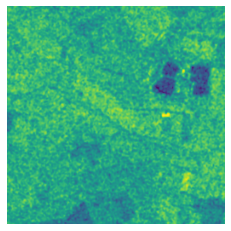

<Axes: >

In [ ]:
#visualize a sample from S1 imagery
fp = r'ROIs2017_winter_s1/s1_102/ROIs2017_winter_s1_102_p101.tif'
img = rasterio.open(fp)
plt.axis('off')
show(img)

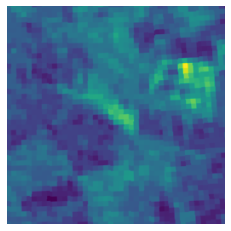

<Axes: >

In [ ]:
#visualize a sample from S2 imagery
fp = r'ROIs2017_winter_s2/s2_102/ROIs2017_winter_s2_102_p101.tif'
img = rasterio.open(fp)
plt.axis('off')
show(img)

In [ ]:
#save the name of the samples and the labels as a dictionary
dic_data = read_data("IGBP_probability_labels.pkl", "pkl")
dic_data = dic_data.reshape((-1,))
winter_key = np.array([x for x in np.array(list(dic_data[0].keys())).\
                       reshape((-1,)) if "winter" in x])
keys = np.array([np.argmax(dic_data[0][x]) for x in winter_key])
for key in winter_key:
    dic_data[0][key]= simpl_igbp(dic_data[0][key])

In [ ]:
#get the name for train and test datasets. 
#The file with names of data for training or testing should be created in advance
test_files = read_data("test_files.csv", "csv", type_save=str)
train_files = read_data("train_files.csv", "csv", type_save=str)
initial_weghts = define_initial_weights()

S2 modality

In [ ]:
#the model to extract features from S2 modality
model_s2 = getResModel_remote((256, 256, 13))
model_s2.compile(optimizer="adam", loss=tf.keras.losses.KLDivergence(),
                 metrics=[metric,"accuracy"])

In [ ]:
#train the model to extract the features from S2 modality
list_classed = os.listdir('./ROIs2017_winter_s2')
data = []
label = []
split_test = 150
for ep in range(40):
    print(f"epoch: {ep}")
    for i in range(200):
    #take a random sample that belongs to train file
        ind = np.random.randint(0, len(list_classed),size=1)[0]
        name_images = os.listdir(f'./ROIs2017_winter_s2/{list_classed[ind]}')
        ind_im =  np.random.randint(0, len(name_images),size=1)[0]
        while name_images[ind_im] in test_files or \
                                max(dic_data[0][name_images[ind_im]])<0.5:
            ind_im = np.random.randint(0, len(name_images),size=1)[0]
        label.append(dic_data[0][name_images[ind_im]])
        image =list(tiff.imread(
            f'./ROIs2017_winter_s2/{list_classed[ind]}/{name_images[ind_im]}'))
        data.append(image)
        if len(data)==200:
                model_s2.fit(np.array(data[:split_test]),np.array(label[:split_test]),
                class_weight = initial_weghts, epochs=10)
                model_s2.evaluate(np.array(data[split_test:]),
                                          np.array(label[split_test:]))
                data = []
                label = []

In [ ]:
#evaluate the qualtity of the classifier for feature extraction 
#save the features for the future visualsation
count =0
data =[]
features_s2 = []
labels = []
feature_model = Model(model_s2.input,model_s2.get_layer("fc2").output)
list_classes = os.listdir('./ROIs2017_winter_s2')
for names in test_files:
    i = 0
    for folders in list_classes:
    if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s2/{folders}'),names)):
        continue
    else:
        image = np.array(list(tiff.imread(f'./ROIs2017_winter_s2/{folders}/{names}'))) 
        data.append(image) 
        image = image[np.newaxis,...]
        features_s2.append(list(feature_model.predict(image)[0].astype(float))) 
        labels.append(dic_data[0][names])
        break
model_s2.evaluate(np.array(data), np.array(labels))

In [ ]:
#visualisation of the feature latent space
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', 
                  perplexity=3).fit_transform(np.array(features_s2))
labels_ = np.array([np.argmax(x) for x in labels])
un = np.unique(labels_)
n_labels = len(un)
color = [list(np.random.choice(range(256), size=3)/256) for i in range(n_labels)]
fig,ax = plt.subplots() 
for i in range(n_labels):
    ind = np.where(labels_==un[i])[0]
    ax.scatter(X_embedded[ind,0],X_embedded[ind,1], c=color[i], alpha=0.5,marker = "o")
plt.axis("off")

In [ ]:
#save test feature space for S2 modality
list_classes = os.listdir('./ROIs2017_winter_s2')
for names in test_files[:3]:
    for folders in list_classes:
    if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s2/{folders}'),names)):
        continue
    else:
        image = np.array(list(tiff.imread(f'./ROIs2017_winter_s2/{folders}/{names}')))
        break
    image = image[np.newaxis,...]
    second_feature = list(feature_model.predict(image)[0].astype(float))
    with open("s2_feature_res_test.csv", "a") as f:
        writer_object = csv.writer(f)
        writer_object.writerow(second_feature)
        f.close()

In [ ]:
#save train feature space for S2 modality
list_classes = os.listdir('./ROIs2017_winter_s2')
feature_model = Model(model_s2.input,model_s2.get_layer("fc2").output)
for names in train_files[:10]:
    for folders in list_classes:
    if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s2/{folders}'),names)):
        continue
    else:
        image = np.array(list(tiff.imread(f'./ROIs2017_winter_s2/{folders}/{names}')))
        break
    image = image[np.newaxis,...]
    second_feature = list(feature_model.predict(image)[0].astype(float))
    with open("s2_feature_res_train.csv", "a") as f:
        writer_object = csv.writer(f)
        writer_object.writerow(second_feature)
        f.close()

S1 modality

In [ ]:
#get model for S1 modality and the names for train and test datasets
model_s1 = getResModel_remote((256, 256, 2))
model_s1.compile(optimizer='adam', loss=tf.keras.losses.KLDivergence(), 
                 metrics=[metric,"accuracy"])
test_files_s1 = [name_transformer(x) for x in test_files]
train_files_s1 = [name_transformer(x) for x in train_files]

In [ ]:
# train a classifier for a feature extraction of S1 modality
list_classed = os.listdir('./ROIs2017_winter_s1')
data = []
label = []
split_test = 150
for ep in range(110):
    print(f"epoch: {ep}")
    for i in range(200):
    #take a random sample that belongs to train file
    ind = np.random.randint(0, len(list_classed),size=1)[0]
    name_images = os.listdir(f'./ROIs2017_winter_s1/{list_classed[ind]}')
    ind_im =  np.random.randint(0, len(name_images),size=1)[0]
    while name_images[ind_im] in test_files_s1 or \
              max(dic_data[0][name_transformer(name_images[ind_im])])<0.5:
        ind_im = np.random.randint(0, len(name_images),size=1)[0]
    t_name_image = name_transformer(name_images[ind_im])
    label.append(dic_data[0][t_name_image])
    image =list(tiff.imread(f'./ROIs2017_winter_s1/{list_classed[ind]}/{name_images[ind_im]}'))
    data.append(image)
    if len(data)==200:
        model_s1.fit(np.array(data[:split_test]),\
                   np.array(label[:split_test]), \
                            class_weight = initial_weghts, epochs=20)
        model_s1.evaluate(np.array(data[split_test:]),
                    np.array(label[split_test:]))
        data = []
        label = []

In [ ]:
#evaluate the qualtity of the classifier for feature extraction 
#save the features for the future visualsation
count =0
data =[]
labels = []
features_s1 = []
feature_model = Model(model_s1.input,model_s1.get_layer("fc2").output)
list_classes = os.listdir('./ROIs2017_winter_s1')
for names in test_files_s1:
    i = 0
    for folders in list_classes:
        if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s1/{folders}'),names)):
            continue
        else:
            image = np.array(list(tiff.imread(f'./ROIs2017_winter_s1/{folders}/{names}'))) 
            data.append(image) 
            image = image[np.newaxis,...]
            features_s1.append(list(feature_model.predict(image)[0].astype(float))) 
            t_name = name_transformer(names)
            labels.append(dic_data[0][t_name])
            break

model_s1.evaluate(np.array(data), np.array(labels))

In [ ]:
#visalize the features coming from S1 modality
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', 
                  perplexity=3).fit_transform(np.array(features_s1))
labels_ = np.array([np.argmax(x) for x in labels])
un = np.unique(labels_)
n_labels = len(un)
color = [list(np.random.choice(range(256), size=3)/256) for i in range(n_labels)]
fig,ax = plt.subplots() 
for i in range(n_labels):
    ind = np.where(labels_==un[i])[0]
    ax.scatter(X_embedded[ind,0],X_embedded[ind,1], c=color[i], alpha=0.5, marker = "o")
plt.axis("off")

In [ ]:
#save the feature space of test S1 modality
list_classes = os.listdir('./ROIs2017_winter_s1')
feature_model = Model(model_s1.input,model_s1.get_layer("fc2").output)
for names in test_files_s1:
    for folders in list_classes:
        if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s1/{folders}'),names)):
            continue
        else:
            image = np.array(list(tiff.imread(f'./ROIs2017_winter_s1/{folders}/{names}')))
            break
    image = image[np.newaxis,...]
    second_feature = list(feature_model.predict(image)[0].astype(float))
    with open("s1_feature_test.csv", "a") as f:
        writer_object = csv.writer(f)
        writer_object.writerow(second_feature)
        f.close()

In [ ]:
#save the feature space of train S1 modality
list_classes = os.listdir('./ROIs2017_winter_s1')
feature_model = Model(model_s1.input,model_s1.get_layer("fc2").output)
for names in train_files_s1:
    for folders in list_classes:
    if not np.any(np.isin(os.listdir(f'./ROIs2017_winter_s1/{folders}'),names)):
        continue
    else:
        image = np.array(list(tiff.imread(f'./ROIs2017_winter_s1/{folders}/{names}')))
        break
    image = image[np.newaxis,...]
    second_feature = list(feature_model.predict(image)[0].astype(float))
    with open("s1_feature_train.csv", "a") as f:
        writer_object = csv.writer(f)
        writer_object.writerow(second_feature)
        f.close()

# ACMR analysis

In [ ]:
#define the models or load the tretrained ones
s1_feature_embed = S1FeatureEmbed()
s2_feature_embed = S2FeatureEmbed()
label_classifier = LabelClassifier()
modality_classifier = ModalityClassifier()
initial_weghts = define_initial_weights()

In [ ]:
EPOCHS = 10
inner_ep = 10
size_part = 7_500

count_lines = 30_000

#define the number of the slices depending on the size of the dataset
group = int(np.ceil(count_lines/size_part))

for epoch in range(EPOCHS):
    print(epoch)
    #since I did not have enough RAM, to load all the data in the same time, 
    #I loaded it by slices.
    for i in range(1,group+1):
        train_s2_feats = read_data(data_info[0]["address"], data_info[0]["type_data"],\
                                   start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_s1_feats = read_data(data_info[1]["address"], data_info[1]["type_data"],\
                                   start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_labels = read_data(data_info[2]["address"], data_info[2]["type_data"],\
                                 type_save=str, start_line=(i-1)*size_part,\
                                end_line = i*size_part)
        #process the labels to clean them and to bring them to a correct format
        t_train_labels = []
        remove_ind = []
        for i,l in enumerate(train_labels):
            l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
            if x!=""]).astype(float)
            simple_label = simpl_igbp(l)
            simple_label[simple_label<0.4]=0
            #if there is no class, which has a class >= 0.4, then delete it
            if np.sum(simple_label)==0:
                remove_ind.append(i)
                continue
            simple_label = simple_label/np.sum(simple_label)
            t_train_labels.append(simple_label)
        train_labels = np.array(t_train_labels)
        train_s2_feats = np.delete(train_s2_feats,remove_ind, axis=0)
        train_s1_feats = np.delete(train_s1_feats,remove_ind, axis=0)
        #shuffle the data and group them in batches
        train_ds = tf.data.Dataset.from_tensor_slices(\
            (train_s2_feats, train_s1_feats, train_labels))\
            .batch(np.ceil(int(len(train_s1_feats)/1))).shuffle(len(train_s1_feats)*4)
        #process the data to get it in correct format for training
        pos_s2_list = np.array([])
        pos_s1_list = np.array([])
        neg_s2_list = np.array([])
        neg_s1_list = np.array([])
        train_labels = np.array([])
        for s2, s1, label in train_ds:
            #check if a batch has at least one dominant class being different
            adj_mat = np.dot(label,np.transpose(label)) 
            min_max = np.max(np.min(adj_mat, axis = 0))
            if min_max == 1:
                continue

            pos_s2,pos_s1,neg_s2,neg_s1 = preprocessing(s2, s1, label)
            pos_s2_list = np.append(pos_s2_list, pos_s2)
            pos_s1_list = np.append(pos_s1_list, pos_s1)
            neg_s2_list = np.append(neg_s2_list, neg_s2)
            neg_s1_list = np.append(neg_s1_list, neg_s1)
            train_labels = np.append(train_labels, label)

        pos_s2_dim = pos_s2.shape[1]
        pos_s1_dim = pos_s1.shape[1]
        neg_s2_dim = neg_s2.shape[1]
        neg_s1_dim = neg_s1.shape[1]
        train_labels = train_labels.reshape((-1,10))
        pos_s2_list = pos_s2_list.reshape((-1,pos_s2_dim))
        pos_s1_list = pos_s1_list.reshape((-1,pos_s1_dim))
        neg_s2_list = neg_s2_list.reshape((-1,neg_s2_dim))
        neg_s1_list = neg_s1_list.reshape((-1,neg_s1_dim))
        merged = tf.concat([pos_s2_list,pos_s1_list,neg_s2_list,neg_s1_list],1)
        #group the data to gain a proper format
        train_ds_split = tf.data.Dataset.from_tensor_slices(
            (merged,train_labels)).batch(np.ceil(int(len(train_s1_feats)/1)))

        for ep in range(inner_ep):
          # Reset the metrics at the start of the next epoch
            modality_loss.reset_states()
            emb_fin__loss.reset_states()
            precision.reset_states()
            label_fin_loss.reset_states()
            triple_fin_loss.reset_states()
            metric.reset_states()
            l = 50*(ep+1)
            i = 0
            for merged_data, labels in train_ds_split:
                i += 1
                ACMR_train_step(merged_data, labels, "kl_diverence", "softmax", \
                                            epoch = epoch+1 , not_skip_index_triple = 3, 
                                            not_skip_index_modality = 2, 
                                            l = np.float32(l))
                #print the results
                print(
                f'Epoch {ep + 1}, '
                f'Image {i + 1}, '
                f'Modality Loss: {modality_loss.result()}, '
                f'Emb loss: {emb_fin__loss.result() }, '
                f'label loss: {label_fin_loss.result() }, '
                f'triple loss: {triple_fin_loss.result() }, '
                f'Acc: {precision.result()*100}, '
                f'F1: {metric.result()*100}, '
                )

In [ ]:
#preprocess testing data 
test_s2_feats = read_data(data_info[3]["address"], data_info[3]["type_data"])
test_s1_feats = read_data(data_info[4]["address"], data_info[4]["type_data"])
test_labels = read_data(data_info[5]["address"], data_info[5]["type_data"], type_save=str)
t_test_labels = []
for i,l in enumerate(test_labels):
    l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
        if x!=""]).astype(float)
    simple_label = simpl_igbp(l)
    simple_label[simple_label>=0.3] = 1
    simple_label[simple_label<0.3] = 0
    t_test_labels.append(simple_label)
test_labels = np.array(t_test_labels)

In [ ]:
label_classifier.compile(optimizer=classifier_optimizer,
                                loss=label_fin_loss, metrics=[metric, 'accuracy'])
print("Test for S1 modality")
label_classifier.evaluate(s1_feature_embed(test_s1_feats).numpy(),test_labels)
print("Test for S2 modality")
label_classifier.evaluate(s2_feature_embed(test_s2_feats).numpy(),test_labels)

Test for S1 modality
125/125 [==============================] - 3s 21ms/step - loss: 0.3141 - f1_score: 0.1438 - accuracy: 0.2533 - label_loss: 0.3223
Test for S2 modality
125/125 [==============================] - 2s 19ms/step - loss: 0.2490 - f1_score: 0.0639 - accuracy: 0.2533 - label_loss: 0.2544


[0.24904993176460266,
 0.06386920809745789,
 0.25325000286102295,
 0.25443294644355774]

# Baselines

## Baseline for S1 modality

In [41]:
baseline_model_s1 = BaseLineS1()
baseline_model_s1.compile(optimizer="adam",\
                                loss=tf.keras.losses.KLDivergence(), \
                                metrics=[metric, 'accuracy'])
initial_weghts = define_initial_weights()

In [ ]:
EPOCHS = 1
inner_ep = 100
size_part = 10_000
count_lines = 30_000
group = int(np.ceil(count_lines/size_part))
for epoch in range(EPOCHS):
    print(epoch)
    for i in range(1,group+1):
        #take the slice of data of data to fit it in the ram
        train_s1_feats = read_data(data_info[1]["address"], data_info[1]["type_data"],\
                                  start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_labels = read_data(data_info[2]["address"], data_info[2]["type_data"],\
                                type_save=str, start_line=(i-1)*size_part,\
                                end_line = i*size_part)
        #clean the labels
        t_train_labels = []
        remove_ind = []
        for i,l in enumerate(train_labels):
            l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
                if x!=""]).astype(float)
            simple_label = simpl_igbp(l)
            simple_label[simple_label<0.4]=0
            if np.sum(simple_label)==0:
                remove_ind.append(i)
                continue
            simple_label = simple_label/np.sum(simple_label)
            t_train_labels.append(simple_label)
        train_labels = np.array(t_train_labels)
        train_s1_feats = np.delete(train_s1_feats,remove_ind, axis=0)

        train_ds = tf.data.Dataset.from_tensor_slices((train_s1_feats, train_labels)).\
        batch(np.ceil(int(len(train_s1_feats)/1))).shuffle(len(train_s1_feats)*4)
        #train
        baseline_model_s1.fit(train_ds, class_weight=initial_weghts, epochs= inner_ep)

In [ ]:
#load testdata for S1 modality
test_s1_feats = read_data(data_info[4]["address"], data_info[4]["type_data"])
test_labels = read_data(data_info[5]["address"], data_info[5]["type_data"], type_save=str)
t_test_labels = []
#format labels
for i,l in enumerate(test_labels):
    l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
        if x!=""]).astype(float)
    simple_label = simpl_igbp(l)
    simple_label[simple_label>=0.3] = 1
    simple_label[simple_label<0.3] = 0
    t_test_labels.append(simple_label)
test_labels = np.array(t_test_labels)

In [ ]:
baseline_model_s1.evaluate(test_s1_feats , test_labels)

## Baseline for S2 modality

In [46]:
baseline_model_s2 = BaseLineS2()
baseline_model_s2.compile(optimizer="adam",\
                                loss=tf.keras.losses.KLDivergence(), \
                                metrics=[metric, 'accuracy'])
initial_weghts = define_initial_weights()

In [ ]:
count_lines = 30_000
EPOCHS = 1
inner_ep = 100
size_part = 10_000
group = int(np.ceil(count_lines/size_part))

for epoch in range(EPOCHS):
    print(epoch)
    for i in range(1,group+1):
        train_s2_feats = read_data(data_info[0]["address"], data_info[0]["type_data"], start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_labels = read_data(data_info[2]["address"], data_info[2]["type_data"], type_save=str, start_line=(i-1)*size_part,\
                                end_line = i*size_part)
        #clean labels
        t_train_labels = []
        remove_ind = []
        for i,l in enumerate(train_labels):
            l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
            if x!=""]).astype(float)
            simple_label = simpl_igbp(l)
            simple_label[simple_label<0.4]=0
            if np.sum(simple_label)==0:
                remove_ind.append(i)
                continue
            simple_label = simple_label/np.sum(simple_label)
            t_train_labels.append(simple_label)
        train_labels = np.array(t_train_labels)
        train_s2_feats = np.delete(train_s2_feats,remove_ind, axis=0)

        train_ds = tf.data.Dataset.from_tensor_slices((train_s2_feats, train_labels)).\
        batch(np.ceil(int(len(train_s2_feats)/1))).shuffle(len(train_s2_feats)*4)
        #train
        baseline_model_s2.fit(train_ds, class_weight=initial_weghts, epochs= inner_ep)

In [ ]:
test_s2_feats = read_data(data_info[3]["address"], data_info[3]["type_data"])
test_labels = read_data(data_info[5]["address"], data_info[5]["type_data"], 
                        type_save=str)
#clean test data
t_test_labels = []
for i,l in enumerate(test_labels):
    l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
        if x!=""]).astype(float)
    simple_label = simpl_igbp(l)
    simple_label[simple_label>=0.3] = 1
    simple_label[simple_label<0.3] = 0
    t_test_labels.append(simple_label)
test_labels = np.array(t_test_labels)

In [ ]:
baseline_model_s2.evaluate(test_s2_feats , test_labels)

# Metric calculation

The following part demonstrates, how the metrics are gained. These exampkes work with test data but it could be also applied to train data

In [33]:
#all analysis requires the test data. The label should not be cleaned
test_s2_feats = read_data(data_info[3]["address"], data_info[3]["type_data"])
test_s1_feats = read_data(data_info[4]["address"], data_info[4]["type_data"])
test_labels = read_data(data_info[5]["address"], data_info[5]["type_data"], type_save=str)
t_test_labels = []
for i,l in enumerate(test_labels):
    l = np.array([x.replace("\n", "") for x in l[1:len(l)-1].split(" ")\
    if x!=""]).astype(float)
    simple_label = simpl_igbp(l)
    t_test_labels.append(simple_label)
test_labels = np.array(t_test_labels)
#some analysis works with the dominant classes
test_trans =np.array([np.argmax(res) for res in test_labels])

In [ ]:
#merged feature space
merged_s1_feature = s1_feature_embed(train_s1_feats).numpy()
merged_s2_feature = s2_feature_embed(train_s2_feats).numpy()
#universal classifier output
predicted_s1= label_classifier(s1_feature_embed(test_s1_feats).numpy()).numpy()
predicted_s2 = label_classifier(s2_feature_embed(test_s2_feats).numpy()).numpy()

In [48]:
# feature space of a baseline.
# if wanted to be tested, the following code should replace
# "merged_s1_feature" and "merged_s2_feature" with the following paramters
base_s1_feature_model = Sequential()
base_s1_feature_model.add(tf.keras.layers.Input(2048,))
base_s1_feature_model.add(baseline_model_s1.get_layer("s1_emb"))

base_s2_feature_model = Sequential()
base_s2_feature_model.add(tf.keras.layers.Input(2048,))
base_s2_feature_model.add(baseline_model_s2.get_layer("s2_emb"))

baseline_s1_feature = base_s1_feature_model(test_s1_feats).numpy()
baseline_s2_feature = base_s2_feature_model(test_s2_feats).numpy()

#matrix calculation use the prediction of the models.
#baselines output
# if it chosen, in the following code 
#"predicted_s1" and "predicted_s2" should be replaced with the parameters
baseline_s1_results = baseline_model_s1(test_s1_feats).numpy()
baseline_s2_results = baseline_model_s2(test_s2_feats).numpy()

###Accuracy of modality classification 

In [ ]:
EPOCHS = 1

size_part = 15_000
count_lines = 30_000
#get a new modaity classifier
modality_classifier = ModalityClassifier()
modality_classifier.compile(optimizer=modality_optimizer,
                                loss=modality_loss, metrics=['accuracy'])
#define the number of the slices depending on the size of the dataset
group = int(np.ceil(count_lines/size_part))

for epoch in range(EPOCHS):
    print(epoch)
    for i in range(1,group+1):
        train_s2_feats = read_data(data_info[0]["address"], data_info[0]["type_data"],\
                                   start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_s1_feats = read_data(data_info[1]["address"], data_info[1]["type_data"],\
                                   start_line=(i-1)*size_part,\
                                  end_line = i*size_part)
        train_labels = read_data(data_info[2]["address"], data_info[2]["type_data"],\
                                 type_save=str, start_line=(i-1)*size_part,\
                                end_line = i*size_part)

        #this part can be changed dependeing on which data you want to test on separability
        s1_feature_space = merged_s1_feature
        s2_feature_space = merged_s2_feature

        with tf.GradientTape() as modality :
            dim = s1_feature_space.shape[0]
            all_emb_s2 = tf.concat([tf.ones([dim, 1]),
                                              tf.zeros([dim, 1])], 1)
            all_emb_s1 = tf.concat([tf.zeros([dim, 1]),
                                              tf.ones([dim, 1])], 1)

            modality_class_loss = tf.math.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(\
                    logits=modality_classifier(s1_feature_space), labels=all_emb_s1) + \
                    tf.nn.softmax_cross_entropy_with_logits(\
                    logits=modality_classifier(s2_feature_space), labels=all_emb_s2)) 

            gradients_modality = modality.gradient(modality_class_loss, 
                                                   modality_classifier.trainable_variables)
            modality_optimizer.apply_gradients(zip(gradients_modality, 
                                                   modality_classifier.trainable_variables))

            modality_loss(modality_class_loss*100)

In [ ]:
#testing how seperatable the modalities are

dim = merged_s1_feature.shape[0]
modality_test_list  = np.append(merged_s1_feature, 
                              merged_s2_feature)

modality_test_list = modality_test_list.reshape(dim*2,-1)
all_emb_s2 = tf.concat([tf.ones([dim, 1]),
                                tf.zeros([dim, 1])], 1)
all_emb_s1 = tf.concat([tf.zeros([dim, 1]),
                                tf.ones([dim, 1])], 1)

all_emb =  np.append(all_emb_s1,all_emb_s2)
all_emb = all_emb.reshape(dim*2,-1)
modality_classifier.evaluate(modality_test_list,all_emb)

## Mean average precision

In [ ]:
mAP(predicted_s1,
    predicted_s2,
    test_trans, k=10)

## Project the modalities with modalities

In [ ]:
#show t-SNE projection of S1 modality
project_one_modality(merged_s1_feature, test_trans)

In [ ]:
#show t-SNE projection of S2 modality
project_one_modality(merged_s2_feature, test_trans)

In [ ]:
#show t-SNE projection for both modalities
project_both_modalities(merged_s1_feature, 
                        merged_s2_feature, test_trans)

In [ ]:
#show how different modalties are blended in the common subspace
seperaction_of_comalities(merged_s1_feature,
                          merged_s2_feature)

## Matrixes

### Confusion matrix

In [ ]:
#show the confusion matrix for S1 modality
build_confusion_matrix(predicted_s1,test_labels)

In [ ]:
#show the confusion matrix for S2 modality
build_confusion_matrix(predicted_s2, test_labels)

### Histogram intersection analysis

In [ ]:
#show the matrix depicting detailed histogram intersection algorithm
homogen_matrix(predicted_s2, predicted_s1)

In [ ]:
#summarize the histogram intersection algorithm per class
summary_homogen_matrix(predicted_s2, predicted_s1)

In [ ]:
#the detailed matrix of how many times 
#a S1 and S2 images with the same labels have one or another predicted class
homogen_matrix_without_histogram(predicted_s2, predicted_s1)

### Distance analysis

In [ ]:
#show how similarity of the features of S1 modality
show_distances_between(merged_s1_feature, merged_s1_feature,test_labels)

In [ ]:
#show how similarity of the features of S2 modality
show_distances_between(merged_s2_feature, merged_s2_feature,test_labels)

In [ ]:
#show how similarity of the features of both modalities
full_predicted= np.append(merged_s1_feature,merged_s2_feature)
full_predicted =full_predicted.reshape((-1,merged_s1_feature.shape[1]))
full_test_labels = np.append(test_labels,test_labels)
full_test_labels =full_test_labels.reshape((-1,test_labels.shape[1]))
show_distances_between(full_predicted, full_predicted,full_test_labels)